# Recommendation Systems
This project involves creating a recommender engine, evaluating it to understand its
performance, and making changes to improve performance. The recommendation dataset will be used is from a collection called MovieLens, which
contains users’ movie ratings and is popular for implementing and testing recommender systems.
The specific dataset we will be using for this lab is MovieLens 100K Dataset which contains 100,000
movie ratings from 943 users and a selection of 1682 movies.

In [ ]:
# import required libraries
!pip install wget
import os
import os.path
import numpy as np
import pandas as pd
from math import sqrt
from heapq import nlargest
from tqdm import trange
from tqdm import tqdm
from scipy import stats
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import wget
from sklearn.preprocessing import normalize

In [ ]:
wget.download("https://github.com/MIE451-1513-2019/course-datasets/raw/master/ml-100k.zip")
!unzip ml-100k.zip
MOVIELENS_DIR = "ml-100k"

Archive:  ml-100k.zip
replace ml-100k/allbut.pl? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


In [ ]:
!ls {MOVIELENS_DIR}

allbut.pl  u1.base  u2.test  u4.base  u5.test  ub.base	u.genre  u.occupation
mku.sh	   u1.test  u3.base  u4.test  ua.base  ub.test	u.info	 u.user
README	   u2.base  u3.test  u5.base  ua.test  u.data	u.item


In [ ]:
def getData(folder_path, file_name):
    fields = ['userID', 'itemID', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(folder_path, file_name), sep='\t', names=fields)
    return data 

In [ ]:
rating_df = getData(MOVIELENS_DIR, 'u.data')

In [ ]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
num_users = len(rating_df.userID.unique())
num_items = len(rating_df.itemID.unique())
print("Number of users:", num_users)
print("Number of items:", num_items)

Number of users: 943
Number of items: 1682


## Part 1: Data Preprocessing and baselien algorithms

Data in recommendation systems is usually encoded as data frame with three or more columns:
(user, item, rating, additional meta-data if present).

In [ ]:
def dataPreprocessor(rating_df, num_users, num_items):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. 
            
        NOTE 1: see where something very similar is done in the lab in function 'buildUserItemMatrix'    
            
        NOTE 2: data can have more columns, but your function should ignore 
              additional columns.
    """
    ########### your code goes here ###########
    matrix=np.zeros((num_users,num_items),dtype=np.int8)
    for (index, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID-1, itemID-1] = rating

    
    
    ###########         end         ###########
    return matrix

In [ ]:
train_matrix=dataPreprocessor(rating_df, num_users, num_items)

Implement the two baseline algorithms (popularity,
user average rating).

In [ ]:
class BaseLineRecSys(object):
    def __init__(self, method, processor=dataPreprocessor):
        """
            method: string. From ['popularity','useraverage']
            processor: function name. dataPreprocessor by default
        """
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.method_name
        
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'popularity': self.popularity,
            'useraverage': self.useraverage,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def useraverage(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByUserAverage'    
        """
        
        
        # Initialize the predicted rating matrix with zeros
        predictionMatrix = np.zeros((num_users, num_items))
        for (user,item),rating in np.ndenumerate(train_matrix):
            userVector=train_matrix[user,:]
            ratedItems=userVector[userVector.nonzero()]
            if ratedItems.size == 0:
                itemAvg=0
            else:
                itemAvg=ratedItems.mean()
            predictionMatrix[user,item]=itemAvg


        


        
        return predictionMatrix
    
    @staticmethod
    def popularity(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByPopularity'    
        """
        
        
        # Initialize the predicted rating matrix with zeros
        predictionMatrix = np.zeros((num_users, num_items))
        vf=np.vectorize(lambda x: 1 if x>=4 else 0)
        itemPopularity=np.zeros((num_items))
        for item in range(num_items):
            numofUsersRated=len(train_matrix[:,item].nonzero()[0])
            numofUsersLiked=len(vf(train_matrix[:,item]).nonzero()[0])
            if numofUsersRated==0:
                itemPopularity[item]=0
            else:
                itemPopularity[item]=numofUsersLiked/numofUsersRated
        for (user,item),rating in np.ndenumerate(train_matrix):
            predictionMatrix[user,item]=itemPopularity[item]


                
        
        return predictionMatrix    
    
    def predict_all(self, train_df, num_users, num_items):
        
        train_matrix = self.processor(train_df, num_users, num_items)
        self.__model = self.method(train_matrix, num_users, num_items)
        
    def evaluate_test(self, test_df, copy=False):
        
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
            
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]

        return prediction
        
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You don not have model..")
            

In [ ]:
popularity_recsys = BaseLineRecSys('popularity')

In [ ]:
popularity_recsys.predict_all(rating_df, num_users, num_items)

In [ ]:
x = popularity_recsys.getModel()

In [ ]:
np.all(x<=1)

True

In [ ]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
popularity_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:13, 1369.05it/s]


,userID,itemID,rating,timestamp,popularity
0,196,242,3,881250949,0.760684
1,186,302,3,891717742,0.804714
2,22,377,1,878887116,0.076923
3,244,51,2,880606923,0.555556
4,166,346,1,886397596,0.611111


In [ ]:
average_user_rating_recsys = BaseLineRecSys('useraverage')

In [ ]:
average_user_rating_recsys.predict_all(rating_df, num_users, num_items)

In [ ]:
average_user_rating_recsys.getModel()

array([[3.61029412, 3.61029412, 3.61029412, ..., 3.61029412, 3.61029412,
        3.61029412],
       [3.70967742, 3.70967742, 3.70967742, ..., 3.70967742, 3.70967742,
        3.70967742],
       [2.7962963 , 2.7962963 , 2.7962963 , ..., 2.7962963 , 2.7962963 ,
        2.7962963 ],
       ...,
       [4.04545455, 4.04545455, 4.04545455, ..., 4.04545455, 4.04545455,
        4.04545455],
       [4.26582278, 4.26582278, 4.26582278, ..., 4.26582278, 4.26582278,
        4.26582278],
       [3.41071429, 3.41071429, 3.41071429, ..., 3.41071429, 3.41071429,
        3.41071429]])

In [ ]:
average_user_rating_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:10, 1422.52it/s]


,userID,itemID,rating,timestamp,useraverage
0,196,242,3,881250949,3.615385
1,186,302,3,891717742,3.413043
2,22,377,1,878887116,3.351562
3,244,51,2,880606923,3.651261
4,166,346,1,886397596,3.550000


## Part 2: Similarity in collaborative filtering

In [ ]:
class SimBasedRecSys(object):

    def __init__(self, base, method, processor=dataPreprocessor):
        """
            base: string. From ['user', 'item']. User-based Similarity or Item-based
            method: string. From ['cosine', 'euclidean', 'somethingelse']
            processor: function name. dataPreprocessor by default
        """
        self.base = base
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.base+'-'+self.method_name
    
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'cosine': self.cosine,
            'euclidean': self.euclidean,
            'somethingelse': self.somethingelse,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def cosine(matrix):
        """
            cosine similarity
        """
        similarity_matrix = 1 - pairwise_distances(matrix, metric='cosine')
        return similarity_matrix
    
    @staticmethod
    def euclidean(matrix):
        """
            euclidean similarity
        """
        
        similarity_matrix=pairwise_distances(matrix,metric='euclidean')
        f=lambda x: 1/(1+x)
        similarity_matrix=f(similarity_matrix)

            
        
        return similarity_matrix
    
    @staticmethod
    def somethingelse(matrix):
        """
            manhattan? or super-natural intuition similarity
        """
        
        similarity_matrix=pairwise_distances(matrix,metric='canberra')
        f=lambda x: 1/(1+x)
        similarity_matrix=f(similarity_matrix)

    
    
               
        return similarity_matrix
        
    def predict_all(self, train_df, num_users, num_items):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_row: scalar. number of users
                num_col: scalar. number of items
            OUTPUT:
                no return... this method assigns the result to self.model
            
            NOTES:
                self.__model should contain predictions for *all* user and items
                (don't worry about predicting for observed (user,item) pairs,
                 since we won't be using these predictions in the evaluation)
                (see code in for an efficient vectorized example)
        """
        train_matrix = self.processor(train_df, num_users, num_items)
        
        if self.base == 'user':
            
            temp_matrix=np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()]=1
            similarity_matrix=self.method(train_matrix)
            normalizer=np.matmul(similarity_matrix,temp_matrix)
            normalizer[normalizer == 0] = 1e-5
            predictionMatrix = np.matmul(similarity_matrix, train_matrix)/normalizer
            num_rated=np.sum(temp_matrix,axis=1)
            num_rated[num_rated==0]=1e5
            useraverage = np.sum(train_matrix, axis=1)/num_rated
            columns = np.sum(predictionMatrix, axis=0)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
            self.__model=predictionMatrix

            
            
        elif self.base == 'item':
            
            temp_matrix=np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()]=1
            similarity_matrix=self.method(train_matrix.T)
            normalizer=np.matmul(temp_matrix,similarity_matrix)
            normalizer[normalizer == 0] = 1e-5
            predictionMatrix = np.matmul(train_matrix,similarity_matrix)/normalizer
            num_rated=np.sum(temp_matrix,axis=0)
            num_rated[num_rated==0]=1e5
            itemaverage = np.sum(train_matrix, axis=0)/num_rated
            rows = np.sum(predictionMatrix, axis=1)
            predictionMatrix[rows==0,:] = predictionMatrix[rows==0,:] + np.expand_dims(itemaverage, axis=0)
            self.__model=predictionMatrix

            
        else:
            print('No other option available')
        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
            NOTE: 1. data can have more columns, but your function should ignore 
                  additional columns.
                  2. 'base-method' depends on your 'base' and 'method'. For example,
                  if base == 'user' and method == 'cosine', 
                  then base-method == 'user-cosine'
                  3. your predictions go to 'base-method' column
        """
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]
    
        return prediction
    
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You do not have model..")

**Cosine similarity works better because it ignores those 0 ratings and only measures similarity between users or items using rating received from both users or items.**

In [ ]:
I=np.eye(3)

In [ ]:
# Examples of how to call similarity functions.
I = dataPreprocessor(rating_df, num_users, num_items)
SimBasedRecSys.cosine(I)

array([[1.        , 0.16693098, 0.04745954, ..., 0.14861694, 0.17950788,
        0.39817474],
       [0.16693098, 1.        , 0.11059132, ..., 0.16148478, 0.17226781,
        0.10579788],
       [0.04745954, 0.11059132, 1.        , ..., 0.10124256, 0.13341615,
        0.02655587],
       ...,
       [0.14861694, 0.16148478, 0.10124256, ..., 1.        , 0.1016418 ,
        0.09511958],
       [0.17950788, 0.17226781, 0.13341615, ..., 0.1016418 , 1.        ,
        0.18246466],
       [0.39817474, 0.10579788, 0.02655587, ..., 0.09511958, 0.18246466,
        1.        ]])

In [ ]:
SimBasedRecSys.euclidean(I)

array([[1.        , 0.01509358, 0.01494397, ..., 0.01558255, 0.01454711,
        0.0158995 ],
       [0.01509358, 1.        , 0.02730523, ..., 0.02920429, 0.02187697,
        0.01843497],
       [0.01494397, 0.02730523, 1.        , ..., 0.03435607, 0.02332047,
        0.01900637],
       ...,
       [0.01558255, 0.02920429, 0.03435607, ..., 1.        , 0.02362505,
        0.01991484],
       [0.01454711, 0.02187697, 0.02332047, ..., 0.02362505, 1.        ,
        0.01781382],
       [0.0158995 , 0.01843497, 0.01900637, ..., 0.01991484, 0.01781382,
        1.        ]])

In [ ]:
SimBasedRecSys.somethingelse(I)

array([[1.        , 0.00331913, 0.00319363, ..., 0.00362387, 0.00329759,
        0.00345465],
       [0.00331913, 1.        , 0.00988049, ..., 0.01384144, 0.00834929,
        0.00467949],
       [0.00319363, 0.00988049, 1.        , ..., 0.01426307, 0.00848216,
        0.00456323],
       ...,
       [0.00362387, 0.01384144, 0.01426307, ..., 1.        , 0.01060071,
        0.00550278],
       [0.00329759, 0.00834929, 0.00848216, ..., 0.01060071, 1.        ,
        0.00471222],
       [0.00345465, 0.00467949, 0.00456323, ..., 0.00550278, 0.00471222,
        1.        ]])

## Part 3: Collaborative filtering
Implement user-user and
item-item based collaborative filtering algorithms 

In [ ]:
user_cosine_recsys = SimBasedRecSys('user','cosine')

In [ ]:
user_cosine_recsys.predict_all(rating_df, num_users, num_items)

In [ ]:
user_cosine_recsys.getModel()

array([[3.89911175, 3.19022667, 3.0261129 , ..., 2.        , 3.        ,
        3.        ],
       [3.84034456, 3.17139889, 2.92626717, ..., 2.        , 3.        ,
        3.        ],
       [3.87104065, 3.12823798, 3.03250708, ..., 2.        , 3.        ,
        3.        ],
       ...,
       [3.90754645, 3.20227238, 3.05776201, ..., 2.        , 3.        ,
        3.        ],
       [3.91100649, 3.21591021, 2.98854017, ..., 2.        , 3.        ,
        3.        ],
       [3.91593122, 3.24268207, 3.08255897, ..., 0.        , 3.        ,
        3.        ]])

In [ ]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
user_cosine_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:07, 1478.96it/s]


,userID,itemID,rating,timestamp,user-cosine
0,196,242,3,881250949,4.025213
1,186,302,3,891717742,4.142828
2,22,377,1,878887116,1.922080
3,244,51,2,880606923,3.431884
4,166,346,1,886397596,3.424963


In [ ]:
class CrossValidation(object):
    def __init__(self, metric, data_path=MOVIELENS_DIR):
        """
            INPUT:
                metric: string. from['RMSE','P@K','R@K']
        """
        self.folds = self._getData(MOVIELENS_DIR)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)
        
    def _getMetric(self, metric_name):
        """
            Don't change this
        """
        switcher = {
            'RMSE': self.rmse,
            'P@K': self.patk,
            'R@K': self.ratk,
            'RPrecision': self.rprecision
        }
        
        return switcher[metric_name]
    
    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        return sqrt(mean_squared_error(data[pred], data[true]))
    
    # Precision at k
    def patk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items retrived
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
    
        # Initialize sum and count vars for average calculation
        sumPrecisions = 0
        countPrecisions = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Calculate precision
            precision = float(len([item for item in topK if item in userTestVector]))/len(topK)

            # Update sum and count
            sumPrecisions += precision
            countPrecisions += 1

        # Return average P@k
        return float(sumPrecisions)/countPrecisions
    
    # Recall at k
    def ratk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRecalls = 0
        countRecalls = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            # Calculate recall
            recall = float(len([item for item in topK if item in userTestVector]))/len(userTestVector)

            # Update sum and count
            sumRecalls += recall
            countRecalls += 1

        # Return average R@k
        return float(sumRecalls)/countRecalls

    def rprecision(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame.
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet = self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRPs = 0
        countRPs = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID, :]


            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID, :]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            topK = nlargest(len(userTestVector), range(len(userVector)), userVector.take)
            # Calculate recall
            rp = float(len([item for item in topK if item in userTestVector])) / len(userTestVector)

            # Update sum and count
            sumRPs += rp
            countRPs += 1

        # Return average R@k
        return float(sumRPs) / countRPs

    @staticmethod
    def getMatrix(rating_df, num_users, num_items, column_name):
        matrix = np.zeros((num_users, num_items))
    
        for (index, userID, itemID, value) in rating_df[['userID','itemID', column_name]].itertuples():
            matrix[userID-1, itemID-1] = value
            
        return matrix
    
    @staticmethod
    def _getData(data_path):
        """
            Don't change this function
        """
        folds = []
        data_types = ['u{0}.base','u{0}.test']
        for i in range(1,6):
            train_set = getData(data_path, data_types[0].format(i))
            test_set = getData(data_path, data_types[1].format(i))
            folds.append([train_set, test_set])
        return folds
    
    def run(self, algorithms, num_users, num_items, k=1):
        """
            5-fold cross-validation
            algorithms: list. a list of algorithms. 
                        eg: [user_cosine_recsys, item_euclidean_recsys]
        """
        
        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items)
                prediction = algorithm.evaluate_test(fold[1])
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))
                
            mean = np.mean(fold_scores)
            ci_low, ci_high = stats.t.interval(0.95, len(fold_scores)-1, loc=mean, scale=stats.sem(fold_scores))
            scores[algorithm.getPredColName()] = [fold_scores, mean, ci_low, ci_high]
            
        results = scores    
    
        return results
            

In [ ]:
# How to use CrossValidation Class?

In [ ]:
# 1. gather your algorithms in previous steps.
algorithm_instances = [SimBasedRecSys('user','cosine'), 
                       SimBasedRecSys('item','cosine') ]

In [ ]:
# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE, P@K, RPrecision
# Precision at K in this example
cv_patk = CrossValidation('RMSE')

In [ ]:
# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# Results include independent results from 5 folds, their mean, and confidence interval.
cv_patk.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm user-cosine


20000it [00:05, 3390.37it/s]
20000it [00:05, 3385.98it/s]
20000it [00:05, 3399.54it/s]
20000it [00:05, 3398.94it/s]
20000it [00:05, 3383.09it/s]


Processing algorithm item-cosine


20000it [00:06, 3323.21it/s]
20000it [00:05, 3358.36it/s]
20000it [00:05, 3363.84it/s]
20000it [00:05, 3386.93it/s]
20000it [00:05, 3398.36it/s]


{'item-cosine': [[1.0377631264364244,
   1.0207280585350078,
   1.0101820660011798,
   1.0136832839209695,
   1.0180579656376574],
  1.020082900106248,
  1.0068242686250732,
  1.0333415315874226],
 'user-cosine': [[1.026449013124381,
   1.0214387664779507,
   1.0132940326457187,
   1.0094003999022947,
   1.0161883961525586],
  1.0173541216605808,
  1.009013080226148,
  1.0256951630950135]}

**User similarity works better, because on average user rates more items than item rated by users, therefore the information about user similarity is more useful than item similarity.**

## Probabilistic Matrix Factorization(PMF)

In [ ]:
class PMFRecSys(object):
    def __init__(self, num_feat=10, epsilon=1, _lambda=0.1, momentum=0.8, maxepoch=20, num_batches=10, batch_size=1000):
        """
            num_feat: int, number of latent features
            epsilon: float, learning rate
            _lambda: float, L2 regularization,
            momentum: float, momentum of the gradient,
            maxepoch: float, Number of epoch before stop,
            num_batches: int, Number of batches in each epoch (for SGD optimization),
            batch_size:Number int, of training samples used in each batches (for SGD optimization)
            
        """
        self.num_feat = num_feat  # Number of latent features,
        self.epsilon = epsilon  # learning rate,
        self._lambda = _lambda  # L2 regularization,
        self.momentum = momentum  # momentum of the gradient,
        self.maxepoch = maxepoch  # Number of epoch before stop,
        self.num_batches = num_batches  # Number of batches in each epoch (for SGD optimization),
        self.batch_size = batch_size  # Number of training samples used in each batches (for SGD optimization)
        self.test = False
        self.w_Item = None  # Item feature vectors
        self.w_User = None  # User feature vectors
        
        self.rmse_train = []
        self.rmse_test = []
        self.pred_column_name='PMF'

    def predict_all(self, train_vec, num_user, num_item):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_user: scalar. number of users
                num_item: scalar. number of items
            OUTPUT:
                no return... this method update w_User and w_Item
            
            NOTES:
                self.W_Item and self.W_User are use to do the final predition for a user
                
        """
        # select 'userID', 'itemID', 'rating only
        train_vec = train_vec.iloc[:, :3].values
        if self.test:
          train_vec, val_vec = train_test_split(train_vec)
          pairs_val = val_vec.shape[0]
          self.mean_rating_test = np.mean(val_vec[:, 2])
        self.mean_rating_train = np.mean(train_vec[:, 2])  # avg rating
        pairs_train = train_vec.shape[0]  # num of rating
        

        # to avoid out of bound
        num_user += 1  
        num_item += 1  
        # initialize
        self.epoch = 0
        
        
    
        self.w_Item = np.sqrt(0.1)+np.random.randn(num_item,self.num_feat)  # item M x D 
        self.w_User = np.sqrt(0.1)+np.random.randn(num_user,self.num_feat)  # user N x D 
    
    
          

        self.w_Item_inc = np.zeros((num_item, self.num_feat))  # accumulate the gradient
        self.w_User_inc = np.zeros((num_user, self.num_feat))  # accumulate the gradient
        while self.epoch < self.maxepoch: 
            self.epoch += 1

            # Shuffle training truples
            shuffled_order = np.arange(train_vec.shape[0])  
            np.random.shuffle(shuffled_order)  #shuffled

            # Batch update
            for batch in range(self.num_batches): 
                # print "epoch %d batch %d" % (self.epoch, batch+1)

                test = np.arange(self.batch_size * batch, self.batch_size * (batch + 1))
                batch_idx = np.mod(test, shuffled_order.shape[0])  # get the real data index


                batch_UserID = np.array(train_vec[shuffled_order[batch_idx], 0], dtype='int32')
                batch_ItemID = np.array(train_vec[shuffled_order[batch_idx], 1], dtype='int32')

                # Compute Compute mean rating subtracted rating  
                
            
                pred_out = np.sum(np.multiply(self.w_Item[batch_ItemID,:],self.w_User[batch_UserID,:]),axis=1) #size (batch_size, )
            
            
                 

                rawErr = pred_out + self.mean_rating_train - train_vec[shuffled_order[batch_idx], 2]

                # Compute gradients
                Ix_User = 2 * np.multiply(rawErr[:, np.newaxis], self.w_Item[batch_ItemID, :]) \
                       + self._lambda * self.w_User[batch_UserID, :]
                Ix_Item = 2 * np.multiply(rawErr[:, np.newaxis], self.w_User[batch_UserID, :]) \
                       + self._lambda * (self.w_Item[batch_ItemID, :])  # np.newaxis :increase the dimension

                dw_Item = np.zeros((num_item, self.num_feat))
                dw_User = np.zeros((num_user, self.num_feat))

                # loop to aggreate the gradients of the same element
                for i in range(self.batch_size):
                    dw_Item[batch_ItemID[i], :] += Ix_Item[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                # Update with momentum
                self.w_Item_inc = self.momentum * self.w_Item_inc + self.epsilon * dw_Item / self.batch_size
                self.w_User_inc = self.momentum * self.w_User_inc + self.epsilon * dw_User / self.batch_size

                self.w_Item = self.w_Item - self.w_Item_inc
                self.w_User = self.w_User - self.w_User_inc

                # Compute Compute mean rating subtracted rating 
                if batch == self.num_batches - 1:
                    train_user_idx = np.array(train_vec[:, 0], dtype='int32')
                    train_item_idx = np.array(train_vec[:, 1], dtype='int32')
                    
            
                    pred_out = np.sum(np.multiply(self.w_Item[train_item_idx,:],self.w_User[train_user_idx,:]),axis=1) # size(pairs_train, )
            
            
                     
                    rawErr = pred_out + self.mean_rating_train - train_vec[:, 2] 
                    obj = np.linalg.norm(rawErr) ** 2 \
                          + 0.5 * self._lambda * (np.linalg.norm(self.w_User) ** 2 + np.linalg.norm(self.w_Item) ** 2)

                    self.rmse_train.append(np.sqrt(obj / pairs_train))

                # Compute validation error
                if batch == self.num_batches - 1 and self.test:
                    val_user_idx = np.array(val_vec[:, 0], dtype='int32')
                    val_item_idx = np.array(val_vec[:, 1], dtype='int32')
                    
            
                    pred_out = np.sum(np.multiply(self.w_Item[val_item_idx,:],self.w_User[val_user_idx,:]),axis=1) #size(pairs_val, )
            
            
                     
                    rawErr = pred_out + self.mean_rating_test - val_vec[:, 2]
                    self.rmse_test.append(np.linalg.norm(rawErr) / np.sqrt(pairs_val))


        

        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
        """
        if copy:
            prediction = pd.DataFrame(test_df.copy(), columns=['userID', 'itemID', 'rating'])
        else:
            prediction = pd.DataFrame(test_df, columns=['userID', 'itemID', 'rating'])
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = (np.dot(self.w_Item, self.w_User[int(userID), :]) + self.mean_rating_train)[int(itemID)]
    
        return prediction
    
    def plot_error(self):
      if self.test:
        plt.plot(range(pmf.maxepoch), pmf.rmse_test, marker='v', label='Test Data')
      plt.plot(range(pmf.maxepoch), pmf.rmse_train, marker='o', label='Training Data')
      plt.title('The MovieLens Dataset Learning Curve')
      plt.xlabel('Number of Epochs')
      plt.ylabel('RMSE')
      plt.legend()
      plt.grid()
      plt.show()
          
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.w_Item = None 
            self.w_User = None 
        except:
            print("You do not have w_Item, w_User")

    def set_params(self, parameters):
        if isinstance(parameters, dict):
            self.num_feat = parameters.get("num_feat", 10)
            self.epsilon = parameters.get("epsilon", 1)
            self._lambda = parameters.get("_lambda", 0.1)
            self.momentum = parameters.get("momentum", 0.8)
            self.maxepoch = parameters.get("maxepoch", 20)
            self.num_batches = parameters.get("num_batches", 10)
            self.batch_size = parameters.get("batch_size", 1000)
            self.test = parameters.get("test_mode", False)
        else:
          raise Exception("You need to pass in a dictionary")

Hyperparameter tuning

In [ ]:
pmf = PMFRecSys()
pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 40, "num_batches": 100,
                "batch_size": 1000, 'test_mode':False})

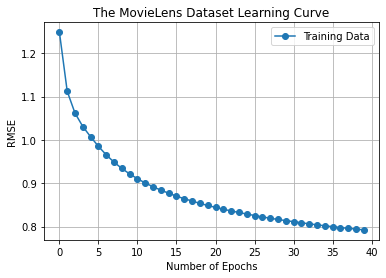

In [ ]:
pmf.predict_all(rating_df, num_users, num_items)
pmf.plot_error()

## Part 5: Performance comparison

In [ ]:
algorithm_instances = [BaseLineRecSys('popularity'),
                       BaseLineRecSys('useraverage'),
                       SimBasedRecSys('user','cosine'), 
                       SimBasedRecSys('item','cosine'),
                       PMFRecSys(10,1,0.1,0.8,40,100,1000)]
metrics=['RMSE','P@K','RPrecision']
result={}
for each in metrics:
    cv_patk = CrossValidation(each)
    r=cv_patk.run(algorithm_instances, num_users, num_items,k=5)
    result[each]=r


Processing algorithm popularity


20000it [00:05, 3386.55it/s]
20000it [00:05, 3371.82it/s]
20000it [00:06, 3307.30it/s]
20000it [00:05, 3385.75it/s]
20000it [00:05, 3396.60it/s]


Processing algorithm useraverage


20000it [00:05, 3388.94it/s]
20000it [00:05, 3421.94it/s]
20000it [00:05, 3382.79it/s]
20000it [00:05, 3431.55it/s]
20000it [00:05, 3464.14it/s]


Processing algorithm user-cosine


20000it [00:05, 3412.99it/s]
20000it [00:05, 3420.75it/s]
20000it [00:05, 3419.51it/s]
20000it [00:05, 3436.57it/s]
20000it [00:05, 3383.79it/s]


Processing algorithm item-cosine


20000it [00:05, 3351.79it/s]
20000it [00:05, 3363.45it/s]
20000it [00:05, 3383.34it/s]
20000it [00:05, 3379.47it/s]
20000it [00:05, 3368.53it/s]


Processing algorithm PMF


20000it [00:10, 1930.82it/s]
20000it [00:10, 1936.61it/s]
20000it [00:10, 1909.42it/s]
20000it [00:10, 1923.96it/s]
20000it [00:10, 1939.29it/s]


Processing algorithm popularity


20000it [00:05, 3374.27it/s]
20000it [00:05, 3433.39it/s]
20000it [00:05, 3433.37it/s]
20000it [00:05, 3440.87it/s]
20000it [00:05, 3476.73it/s]


Processing algorithm useraverage


20000it [00:05, 3441.73it/s]
20000it [00:05, 3431.90it/s]
20000it [00:05, 3417.14it/s]
20000it [00:05, 3390.17it/s]
20000it [00:05, 3435.30it/s]


Processing algorithm user-cosine


20000it [00:05, 3435.21it/s]
20000it [00:05, 3395.79it/s]
20000it [00:05, 3371.93it/s]
20000it [00:05, 3423.02it/s]
20000it [00:05, 3413.94it/s]


Processing algorithm item-cosine


20000it [00:05, 3407.04it/s]
20000it [00:06, 3314.38it/s]
20000it [00:05, 3388.84it/s]
20000it [00:05, 3402.47it/s]
20000it [00:05, 3375.40it/s]


Processing algorithm PMF


20000it [00:10, 1933.84it/s]
20000it [00:10, 1958.65it/s]
20000it [00:10, 1946.40it/s]
20000it [00:10, 1917.38it/s]
20000it [00:10, 1927.10it/s]


Processing algorithm popularity


20000it [00:05, 3421.37it/s]
20000it [00:05, 3413.09it/s]
20000it [00:05, 3359.58it/s]
20000it [00:05, 3435.44it/s]
20000it [00:05, 3412.78it/s]


Processing algorithm useraverage


20000it [00:05, 3448.75it/s]
20000it [00:05, 3501.14it/s]
20000it [00:05, 3388.20it/s]
20000it [00:05, 3428.70it/s]
20000it [00:05, 3456.52it/s]


Processing algorithm user-cosine


20000it [00:05, 3441.73it/s]
20000it [00:05, 3444.96it/s]
20000it [00:05, 3432.83it/s]
20000it [00:05, 3403.49it/s]
20000it [00:05, 3424.36it/s]


Processing algorithm item-cosine


20000it [00:05, 3399.91it/s]
20000it [00:05, 3408.39it/s]
20000it [00:05, 3458.64it/s]
20000it [00:06, 3329.26it/s]
20000it [00:05, 3443.99it/s]


Processing algorithm PMF


20000it [00:10, 1940.10it/s]
20000it [00:10, 1920.07it/s]
20000it [00:10, 1926.93it/s]
20000it [00:10, 1891.78it/s]
20000it [00:10, 1946.41it/s]


In [ ]:
result_dict=result.copy()

In [ ]:
algorithms=['popularity','useraverage','user-cosine','item-cosine','PMF']
for m in metrics:
    for a in algorithms:
        result_dict[m][a]=result_dict[m][a][1:]
        result_dict[m][a]=[round(x,4) for x in result_dict[m][a]]

In [ ]:
result_df=pd.DataFrame(result_dict)

In [ ]:
result_df

,RMSE,P@K,RPrecision
popularity,"[3.1591, 3.1393, 3.1789]","[0.5506, 0.4054, 0.6957]","[0.7177, 0.7068, 0.7285]"
useraverage,"[1.0437, 1.0289, 1.0585]","[0.4736, 0.342, 0.6053]","[0.6457, 0.6396, 0.6518]"
user-cosine,"[1.0174, 1.009, 1.0257]","[0.5558, 0.4096, 0.7021]","[0.721, 0.71, 0.732]"
item-cosine,"[1.0201, 1.0068, 1.0333]","[0.5322, 0.3837, 0.6807]","[0.708, 0.7007, 0.7153]"
PMF,"[0.9971, 0.9785, 1.0157]","[0.5349, 0.388, 0.6818]","[0.6943, 0.6854, 0.7033]"


## Part 6: Similarity evaluation

In [ ]:
fieldsMovies = ['movieID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 'IMDbURL', 'unknown', 'action', 'adventure',
          'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror',
          'musical', 'mystery', 'romance','sciFi', 'thriller', 'war', 'western']
moviesDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.item'), sep='|', names=fieldsMovies, encoding='latin-1')

moviesDF.head()

,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [ ]:
id_list=[1,22,100]

In [ ]:
similarityMatrix=SimBasedRecSys.cosine(train_matrix.T)

In [ ]:
similar_movies_result={}
for each in id_list:
    top_5=similarityMatrix[each].argsort()[-6:-1]
    similar_movies_result[each]=top_5
for each in id_list:
    print('Top 5 similar movies for {}:'.format(moviesDF[moviesDF['movieID']==each]['movieTitle'].values[0]))
    for m in similar_movies_result[each]:
        print(moviesDF[moviesDF['movieID']==m]['movieTitle'].values[0])


Top 5 similar movies for Toy Story (1995):
Three Colors: White (1994)
Ghost (1990)
Naked Gun 33 1/3: The Final Insult (1994)
Glengarry Glen Ross (1992)
Young Guns (1988)
Top 5 similar movies for Braveheart (1995):
Army of Darkness (1993)
Touch of Evil (1958)
Return of the Jedi (1983)
12 Angry Men (1957)
Blues Brothers, The (1980)
Top 5 similar movies for Fargo (1996):
So I Married an Axe Murderer (1993)
Star Trek VI: The Undiscovered Country (1991)
When Harry Met Sally... (1989)
Tales From the Crypt Presents: Demon Knight (1995)
Duck Soup (1933)


## Part 7: Testing with different user types

In [ ]:
train_matrix[train_matrix.nonzero()]=1
count=np.sum(train_matrix,axis=1)
hist=np.histogram(count,bins=100)
hist_dist=stats.rv_histogram(hist)

Text(0, 0.5, 'Number of users')

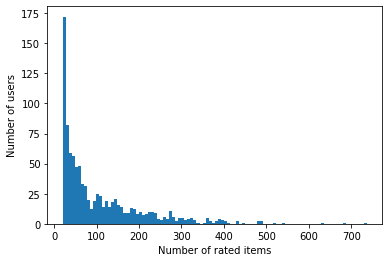

In [ ]:
plt.hist(count, bins=100)
plt.xlabel('Number of rated items')
plt.ylabel('Number of users')

**User-user similarity**

In [ ]:
active_index=np.where(count>150)
active_userid=active_index[0]+1
inactive_index=np.where(count<=150)
inactive_userid=inactive_index[0]+1

In [ ]:
user_cosine_recsys = SimBasedRecSys('user','cosine')
user_cosine_recsys.predict_all(rating_df, num_users, num_items)
user_cosine_recsys.getModel()
predict_df=user_cosine_recsys.evaluate_test(rating_df,copy=True)


100000it [01:07, 1484.95it/s]


In [ ]:
active_user_df=predict_df.loc[predict_df['userID'].isin(active_userid)]
inactive_user_df=predict_df.loc[predict_df['userID'].isin(inactive_userid)]

In [ ]:
CrossValidation.rmse(active_user_df,None,num_users,num_items,'user-cosine','rating')

0.9501387957272239

In [ ]:
CrossValidation.rmse(inactive_user_df,None,num_users,num_items,'user-cosine','rating')

0.9695637272362744

**Item-item simlarity**

In [ ]:
item_cosine_recsys = SimBasedRecSys('item','cosine')
item_cosine_recsys.predict_all(rating_df, num_users, num_items)
item_cosine_recsys.getModel()
new_predict_df=item_cosine_recsys.evaluate_test(rating_df,copy=True)

100000it [01:07, 1485.88it/s]


In [ ]:
new_active_user_df=new_predict_df.loc[new_predict_df['userID'].isin(active_userid)]
new_inactive_user_df=new_predict_df.loc[new_predict_df['userID'].isin(inactive_userid)]

In [ ]:
CrossValidation.rmse(new_active_user_df,None,num_users,num_items,'item-cosine','rating')

0.9881581903262271

In [ ]:
CrossValidation.rmse(new_inactive_user_df,None,num_users,num_items,'item-cosine','rating')

0.9557081790728622

For users rated more items the similarity between these two users will be more accurate than the similarity between two users barely rated any items.